In [6]:
import pandas as pd
from utils import data_wrangling as dw
from utils import ts_wrangling as tw
from utils import plots 
from models import lf_models
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import seaborn as sns
import pickle
import joblib

from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    CrostonOptimized,
    TSB,
    MSTL,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
)

In [7]:
INIT = "2012-01-01"
END = "2023-02-28"
PERIOD = 24*365
HORIZON = 24*2

# Dados

In [8]:
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
df_load = dw.pipeline(load).loc[INIT:END,:]
df_load = df_load.iloc[-PERIOD:,:]
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-03-01 00:00:00 to 2023-02-28 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_reg      8760 non-null   category
 1   desc_reg    8760 non-null   category
 2   load_mwmed  8760 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 154.4 KB


In [9]:
df_load.describe()

,load_mwmed
count,8760.000000
mean,11641.760189
std,2295.359889
min,5755.558000
25%,9782.649250
50%,11768.670030
75%,13344.280750
max,18345.403000


In [10]:
train, test = tw.train_test_split(df_load, test=HORIZON)

# Modelos

In [23]:
# df_fc = lf_models.auto_arima_model(df=train, h_=HORIZON)
# df_fc.head()

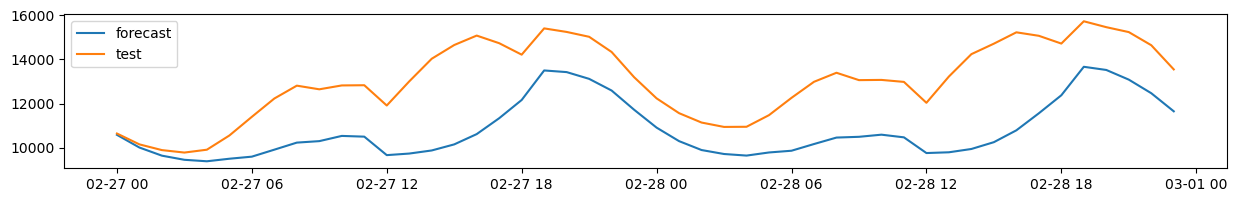

In [36]:
# plt.figure(figsize=(15,2))
# plt.plot(df_fc.ds, df_fc.AutoARIMA, label="forecast")
# plt.plot(test.index, test.load_mwmed, label="test")
# plt.legend()
# plt.show()

# Comparação de modelos

In [54]:
df_sf = dw.prepare_statsforecast_df(train, "hourly_load")

In [55]:
sf, forecasts_df = lf_models.compare_models(df=train, h_=HORIZON, level=[90,95,99])

In [16]:
# forecasts_df_arima = forecasts_df[[x for x in forecasts_df.columns if "ARIMA" in x or "ds" in x]]
# forecasts_df_arima.head()

In [8]:
forecasts_df.head()

,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoARIMA-hi-95,AutoARIMA-hi-99,CrostonClassic,CrostonOptimized,...,AutoETS-hi-95,AutoETS-hi-99,CES,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,AutoTheta-lo-95,AutoTheta-hi-95,AutoTheta-lo-99,AutoTheta-hi-99
unique_id,,,,,,,,,,,,,,,,,,,,,
hourly_load,2023-02-27 00:00:00,10583.355469,9818.888672,10001.667969,10095.188477,11071.523438,11165.043945,11347.823242,10750.967773,11754.276367,...,12614.221680,13011.828125,11460.994141,11335.722656,10354.405273,12573.477539,10263.340820,12612.908203,9873.739258,12827.451172
hourly_load,2023-02-27 01:00:00,10007.152344,8580.058594,8921.267578,9095.849609,10918.455078,11093.037109,11434.246094,10750.967773,11754.276367,...,13162.786133,13726.069336,11423.147461,11335.722656,9852.372070,12884.868164,9511.812500,13044.305664,9174.249023,13708.076172
hourly_load,2023-02-27 02:00:00,9638.824219,7719.761719,8178.598145,8413.363281,10864.285156,11099.050781,11557.886719,10750.967773,11754.276367,...,13590.881836,14281.987305,11376.624023,11335.722656,9185.199219,13169.217773,8942.464844,13455.631836,8699.185547,14012.373047
hourly_load,2023-02-27 03:00:00,9451.693359,7219.575195,7753.261230,8026.324219,10877.062500,11150.125977,11683.811523,10750.967773,11754.276367,...,13956.975586,14756.420898,11337.295898,11335.722656,9159.901367,13208.197266,8853.460938,13802.066406,8025.460938,14847.213867
hourly_load,2023-02-27 04:00:00,9384.501953,6976.620117,7552.330078,7846.894531,10922.108398,11216.672852,11792.382812,10750.967773,11754.276367,...,14283.671875,15179.077148,11292.523438,11335.722656,9096.256836,13600.580078,8364.412109,14128.871094,7620.568848,14514.342773


In [10]:
crossval_df = lf_models.crossval(sf=sf, data=df_sf)
metrics_df, top = lf_models.crossval_summary_table(crossval_df)


In [11]:
metrics_df

,AutoARIMA,CrostonClassic,CrostonOptimized,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,MSTL,AutoETS,CES,AutoTheta,best_model,metric
unique_id,,,,,,,,,,,,
hourly_load,1.652954e+03,2.247784e+03,2.459183e+03,1.410173e+03,1.646164e+03,1.571671e+03,458.485962,1.973990e+03,1.806755e+03,1.855117e+03,MSTL,mean_absolute_error
hourly_load,3.841199e+06,6.134624e+06,7.393277e+06,2.976568e+06,3.555754e+06,3.668218e+06,308453.468750,4.823229e+06,3.739583e+06,4.175892e+06,MSTL,mean_squared_error
hourly_load,3.841199e+06,6.134624e+06,7.393277e+06,2.976568e+06,3.555754e+06,3.668218e+06,308453.468750,4.823229e+06,3.739583e+06,4.175892e+06,MSTL,mean_squared_error
hourly_load,1.676916e-01,2.295654e-01,2.527711e-01,1.408378e-01,1.695073e-01,1.583805e-01,0.044464,2.032261e-01,1.810998e-01,1.897660e-01,MSTL,mean_absolute_percentage_error
hourly_load,-1.179998e+00,-2.511303e+00,-3.132295e+00,-8.618599e-01,-7.641998e-01,-1.009915e+00,0.833807,-1.643322e+00,-1.030364e+00,-1.278093e+00,CrostonOptimized,r2_score
hourly_load,1.494434e-01,2.011608e-01,2.180046e-01,1.275014e-01,1.534643e-01,1.410429e-01,0.045788,1.800134e-01,1.667923e-01,1.704277e-01,MSTL,MeanAbsolutePercentageError


In [12]:
top # MELHOR MODELO: MSTL

,0
best_model,
CrostonOptimized,1
MSTL,5


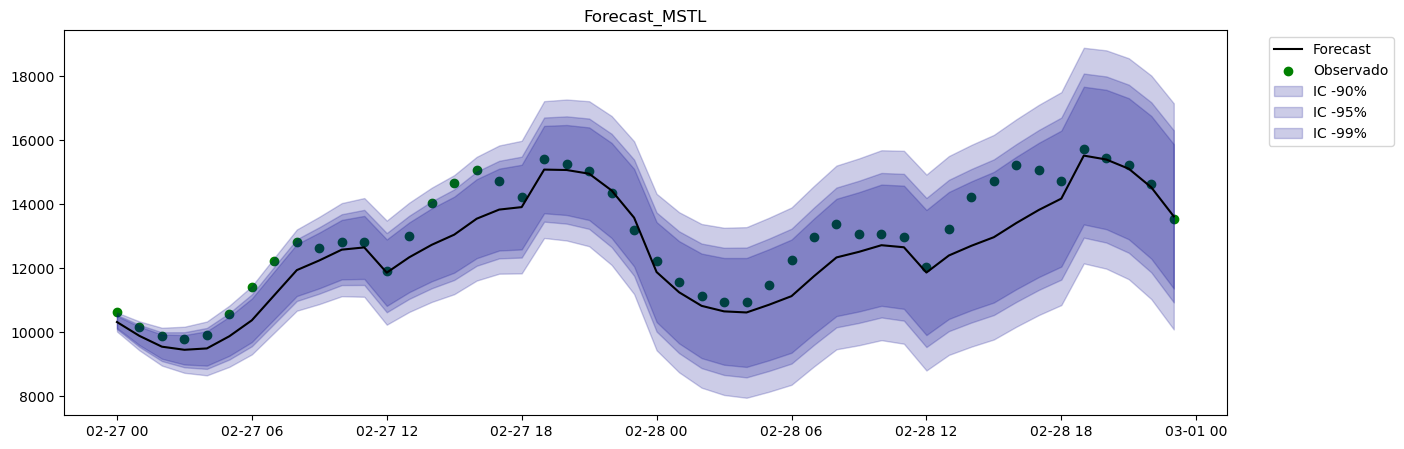

In [21]:
MSTL_fcs = tw.extract_model_cols(forecasts_df, "MSTL")
plots.plot_with_confidence(data=MSTL_fcs, x_="ds", y_="MSTL", levels=[90,95,99], test=test["load_mwmed"], title_=f"Forecast_MSTL", save=True)

In [20]:
# fcs_path = "fcs_data/"
# forecasts_df.to_excel(''.join([fcs_path,"forecasts_df.xlsx"]))
# metrics_df.to_excel(''.join([fcs_path,"metrics_df.xlsx"]))

# Prophet

In [6]:
import fbprophet
from fbprophet.diagnostics import cross_validation
import datetime as dt
from models import lf_models

In [7]:
train_ts = train.reset_index()[["date","load_mwmed"]]
train_ts.columns = ['ds', 'y']
train_ts

,ds,y
0,2022-03-01 00:00:00,13519.673
1,2022-03-01 01:00:00,12853.674
2,2022-03-01 02:00:00,12314.595
3,2022-03-01 03:00:00,12097.324
4,2022-03-01 04:00:00,12025.326
...,...,...
8707,2023-02-26 19:00:00,12980.548
8708,2023-02-26 20:00:00,13008.336
8709,2023-02-26 21:00:00,12665.633
8710,2023-02-26 22:00:00,12147.929


In [14]:
model = fbprophet.Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_ts)

c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


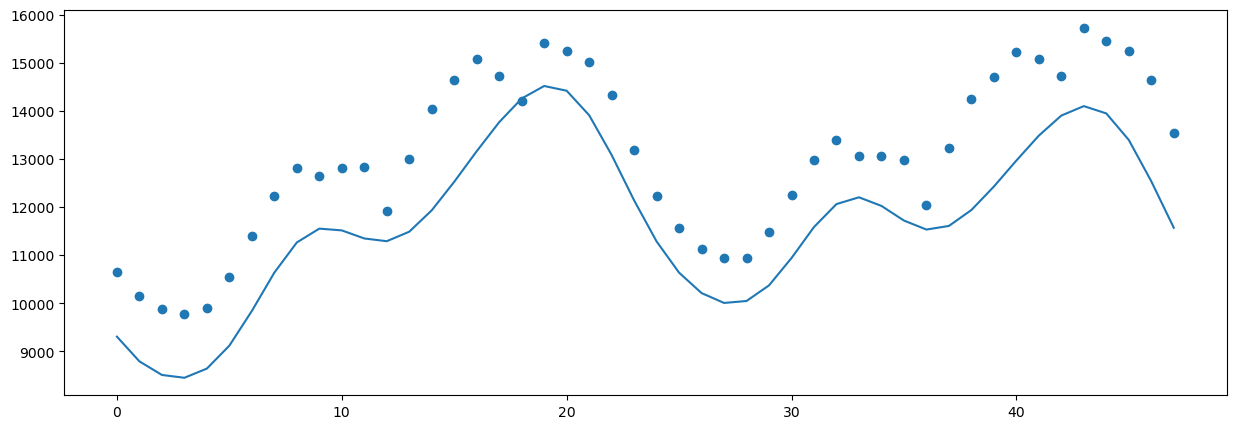

In [15]:
future_fbp = model.make_future_dataframe(periods=48, freq='h', include_history=False)
forecast = model.predict(future_fbp)
plt.figure(figsize=(15,5))
plt.plot(forecast.index, forecast.yhat)
plt.scatter(forecast.index, test.load_mwmed)
plt.show()

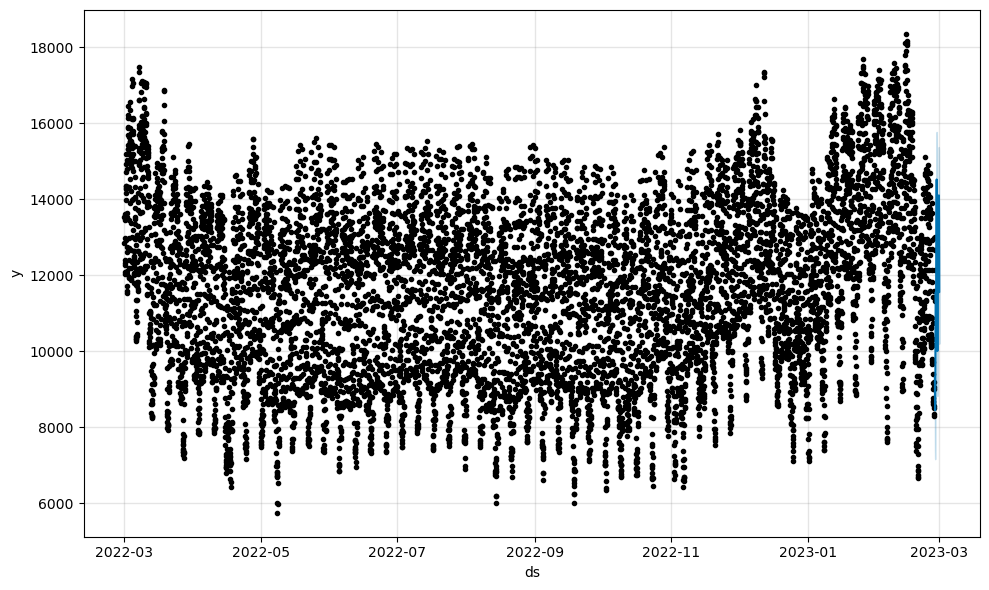

In [109]:
model.plot(forecast)
plt.show()

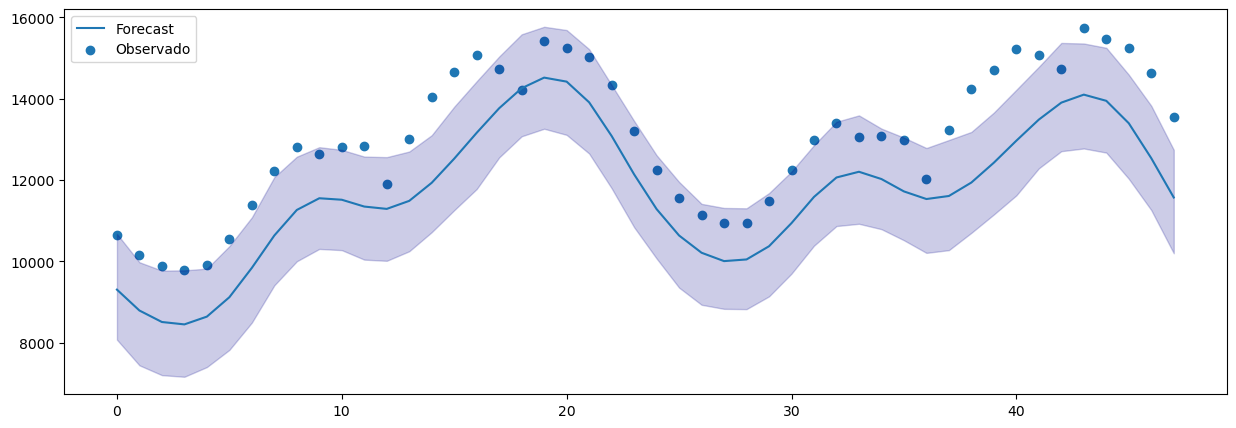

In [103]:
plt.figure(figsize=(15,5))
plt.plot(forecast.index, forecast.yhat, label="Forecast")
plt.scatter(forecast.index, test.load_mwmed, label="Observado")
plt.fill_between(forecast.index, forecast.yhat_upper, forecast.yhat_lower, alpha=.2, color="darkblue")
plt.legend()
plt.show()

In [9]:
train.head(2)

,id_reg,desc_reg,load_mwmed
date,,,
2022-03-01 00:00:00,S,SUL,13519.673
2022-03-01 01:00:00,S,SUL,12853.674


In [ ]:
# def prophet_model(data: pd.DataFrame, 
#                   date_col: str, 
#                   y_col: str, 
#                   horizon: int, 
#                   test: pd.DataFrame=None,
#                   frequency: str='h'):
#     """_summary_

#     Args:
#         data (pd.DataFrame): _description_
#         date_col (str): _description_
#         y_col (str): _description_
#         horizon (int): _description_
#         test (pd.DataFrame, optional): _description_. Defaults to None.
#         frequency (str, optional): _description_. Defaults to 'h'.

#     Returns:
#         _type_: _description_
#     """
#     df = data[[date_col,y_col]]
#     df.rename(columns={
#                 date_col: 'ds', 
#                 y_col: 'y'
#                 }, inplace=True)
#     #print(df)
#     model = fbprophet.Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
#     model.fit(df)
#     future_fbp = model.make_future_dataframe(periods=horizon, freq=frequency, include_history=False)
#     forecast = model.predict(future_fbp)
#     plt.figure(figsize=(15,5))
#     plt.plot(forecast['ds'], forecast.yhat, label="Forecast")
#     plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'], alpha=.2, color="darkblue")
#     if test is not None:
#         plt.scatter(test[date_col], test[y_col], label="Observado")
#     plt.legend()
#     plt.show()
#     return forecast

fc = lf_models.prophet_model(data=train.reset_index(), date_col="date", y_col="load_mwmed", horizon=48, test=test.reset_index())

In [ ]:
fc

## Cross validation
https://stackoverflow.com/questions/63780573/trying-to-understand-fb-prophet-cross-validation


In [94]:
initial = '332 days'
horizon = '48 hours'
period = '24 hours' #cutoff (steps); := initial + period
df_cv = cross_validation(model, horizon=horizon, period=period, initial=initial)

  0%|          | 0/29 [00:00<?, ?it/s]

c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

In [96]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-28 00:00:00,13316.006968,12151.724678,14547.166949,15316.058,2023-01-27 23:00:00
1,2023-01-28 01:00:00,12594.480723,11465.841677,13906.182778,14431.520,2023-01-27 23:00:00
2,2023-01-28 02:00:00,12093.593182,10796.437444,13391.207218,13751.679,2023-01-27 23:00:00
3,2023-01-28 03:00:00,11815.349485,10694.033845,13035.402673,13308.677,2023-01-27 23:00:00
4,2023-01-28 04:00:00,11794.286909,10581.962266,12997.064665,12958.667,2023-01-27 23:00:00
...,...,...,...,...,...,...
1387,2023-02-26 19:00:00,11635.037790,10269.780916,12861.877390,12980.548,2023-02-24 23:00:00
1388,2023-02-26 20:00:00,11618.020664,10242.701149,12938.742752,13008.336,2023-02-24 23:00:00
1389,2023-02-26 21:00:00,11205.401601,9988.527647,12417.802886,12665.633,2023-02-24 23:00:00
1390,2023-02-26 22:00:00,10486.197451,9236.360056,11717.419175,12147.929,2023-02-24 23:00:00


# AutoARIMA

In [62]:
sf, df_forecast = lf_models.auto_arima_model(df=train,
                                             h_=48,
                                             level=[99,95,90])

## Saving models

In [12]:
joblib.dump(sf, 'models/sf_autoarima_joblib')

['models/sf_autoarima_joblib']

In [13]:
sf_autoarima = joblib.load('models/sf_autoarima_joblib')

## Tentando extrair ordem dos parâmetros do AutoARIMA

In [67]:
sf.models[0].model_ # erro; precisa rodar .fit antes no modelo

AttributeError: 'AutoARIMA' object has no attribute 'model_'

In [68]:
sf.models[0].fit(df_sf["y"].values)

AutoARIMA

In [ ]:
sf.models[0].model_

In [ ]:
sf_autoarima.forecast(h=48)

In [40]:
from utils.data_wrangling import prepare_statsforecast_df
df_sf = prepare_statsforecast_df(train, 'hora')
sf_autoarima.models[0].fit(df_sf["y"].values)

AutoARIMA

In [52]:
from pprint import pprint
model_coefs = sf_autoarima.models[0].model_
pprint(model_coefs)
# {'arma': (3, 0, 2, 0, 24, 0, 1),
#  'bic': 123629.39790400655,
#  'coef': {'ar1': 1.576349293178381,
#           'ar2': -0.8065257665446013,
#           'ar3': 0.11690463743052477,
#           'sar1': -0.2764573522131184,
#           'sar2': -0.3354229188825696}

{'aic': 123586.98040640098,
 'aicc': 123586.99008382033,
 'arma': (3, 0, 2, 0, 24, 0, 1),
 'bic': 123629.39790400655,
 'code': 2,
 'coef': {'ar1': 1.576349293178381,
          'ar2': -0.8065257665446013,
          'ar3': 0.11690463743052477,
          'sar1': -0.2764573522131184,
          'sar2': -0.3354229188825696},
 'ic': None,
 'lambda': None,
 'loglik': -61787.49020320049,
 'mask': array([ True,  True,  True,  True,  True]),
 'model': {'P': array([[ 0.00000000e+00,  1.50171527e-16, -6.86035459e-17, ...,
        -2.77116253e-15, -2.14743864e-15, -3.98027317e-18],
       [ 1.50171527e-16, -7.98075322e-16,  1.73860873e-16, ...,
         6.93518279e-16,  6.78412077e-16, -1.50171527e-16],
       [-6.86035459e-17,  1.73860873e-16,  1.91453679e-16, ...,
        -1.27125497e-16,  1.27941396e-16,  6.86035459e-17],
       ...,
       [-2.77116253e-15,  6.93518279e-16, -1.27125497e-16, ...,
        -2.86209475e-17, -1.65687982e-29, -1.23942252e-29],
       [-2.14743864e-15,  6.78412077e-16,

In [45]:
model_coefs["arma"]

(3, 0, 2, 0, 24, 0, 1)